In [17]:
!mkdir /content/drive/MyDrive/brAIns/feedback/bigbird

In [18]:
!unzip /content/drive/MyDrive/brAIns/feedback/bigbird_v26.pt.zip -d /content/drive/MyDrive/brAIns/feedback/bigbird

Archive:  /content/drive/MyDrive/brAIns/feedback/bigbird_v26.pt.zip
  inflating: /content/drive/MyDrive/brAIns/feedback/bigbird/bigbird_v26.pt  


In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 6.6 MB 40.6 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
     |████████████████████████████████| 880 kB 56.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=74f8b9d54c4973297a32b356b095e429ee19b0508522b179435b0b18e60a64b4
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [35]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import os

In [24]:
fDir = '/content/drive/MyDrive/brAIns/feedback/'

train = pd.read_csv(fDir + 'train.csv')

train[['discourse_id', 'discourse_start', 'discourse_end']] = train[['discourse_id', 'discourse_start', 'discourse_end']].astype(int)

In [26]:
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


- **id** - ID code for essay response
- **discourse_id** - ID code for discourse element
- **discourse_start** - character position where discourse - - element begins in the essay response
- **discourse_end** - character position where discourse element ends in the essay response
- **discourse_text** - text of discourse element
- **discourse_type** - classification of discourse element
- **discoursetypenum** - enumerated class label of discourse element
- **predictionstring** - the word indices of the training sample, as required for predictions

**Lead** - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis\
\
**Position** - an opinion or conclusion on the main question\
\
**Claim** - a claim that supports the position\
\
**Counterclaim** - a claim that refutes another claim or gives an opposing reason to the position\
\
**Rebuttal** - a claim that refutes a counterclaim\
\
**Evidence** - ideas or examples that support claims, counterclaims, or rebuttals.\
\
**Concluding Statement** - a concluding statement that restates the claims

In [30]:
!cat /content/drive/MyDrive/brAIns/feedback/train/423A1CA112E2.txt

Phones

Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.

When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.

Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. S

In [31]:
train["discourse_len"] = train["discourse_text"].apply(lambda x: len(x.split()))
train["pred_len"] = train["predictionstring"].apply(lambda x: len(x.split()))

cols_to_display = ['discourse_id', 'discourse_text', 'discourse_type','predictionstring', 'discourse_len', 'pred_len']
train[cols_to_display].head()

,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
0,1622627660524,Modern humans today are always on their phone....,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,44,44
1,1622627653021,They are some really bad consequences when stu...,Position,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,15,15
2,1622627671020,Some certain areas in the United States ban ph...,Evidence,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,16,16
3,1622627696365,"When people have phones, they know about certa...",Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,63,63
4,1622627759780,Driving is one of the way how to get around. P...,Claim,139 140 141 142 143 144 145 146 147 148 149 15...,24,24


In [32]:
print(f"The total number of discourses is {len(train)}")
train.query('discourse_len != pred_len')[cols_to_display]

The total number of discourses is 144293


,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
107,1622473475289,if we would just make stricker laws for phone ...,Concluding Statement,303 304 305 306 307 308 309 310 311 312 313 31...,19,18
1025,1622564912260,for navigation to wherever they are going,Claim,105 106 107 108 109 110 111 112,7,8
1525,1622992466917,People should not be able to use cell phones w...,Position,22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 3...,47,48
1526,1622992280991,"First, cell phones are a benefit and allows ev...",Claim,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 8...,21,22
1527,1622992426147,"Kids, teenagers, adults, even grandparents hav...",Evidence,90 91 92 93 94 95 96 97 98 99 100 101 102 103 ...,78,79
...,...,...,...,...,...,...
142607,1617826841342,seeking people's opinions on making a choice i...,Concluding Statement,563 564 565 566 567 568 569 570 571 572 573 57...,51,50
143191,1617887956153,i feel like for the bst advice ask more then o...,Evidence,185 186 187 188 189 190 191 192 193 194 195 19...,83,82
143227,1617652582742,", asking for advice from multiple people will ...",Concluding Statement,467 468 469 470 471 472 473 474 475 476 477 47...,84,83
143311,1618286838241,Seeking multiple opinions can help make a bett...,Claim,159 160 161 162 163 164 165 166 167 168 169 17...,15,16


In [33]:
print(train.query('discourse_id == 1622473475289')['discourse_text'].values[0])
print(train.query('discourse_id == 1622473475289')['discourse_text'].values[0].split())
print(len(train.query('discourse_id == 1622473475289')['discourse_text'].values[0].split()))

if we would just make stricker laws for phone an driving the people would stop because of the consequences.      
['if', 'we', 'would', 'just', 'make', 'stricker', 'laws', 'for', 'phone', 'an', 'driving', 'the', 'people', 'would', 'stop', 'because', 'of', 'the', 'consequences.']
19


https://www.kaggle.com/c/feedback-prize-2021/discussion/297591

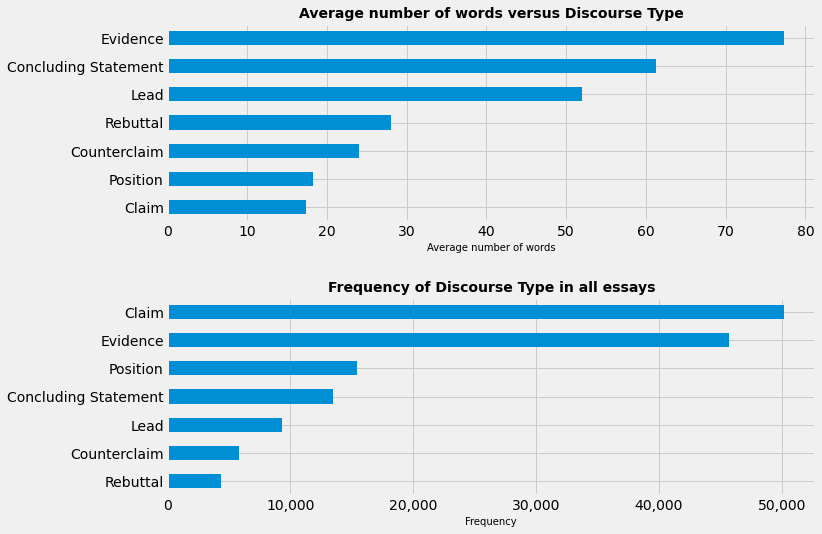

In [36]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
ax1 = train.groupby('discourse_type')['discourse_len'].mean().sort_values().plot(kind="barh")
ax1.set_title("Average number of words versus Discourse Type", fontsize=14, fontweight = 'bold')
ax1.set_xlabel("Average number of words", fontsize = 10)
ax1.set_ylabel("")

ax2 = fig.add_subplot(212)
ax2 = train.groupby('discourse_type')['discourse_type'].count().sort_values().plot(kind="barh")
ax2.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
ax2.set_title("Frequency of Discourse Type in all essays", fontsize=14, fontweight = 'bold')
ax2.set_xlabel("Frequency", fontsize = 10)
ax2.set_ylabel("")

plt.tight_layout(pad=2)
plt.show()

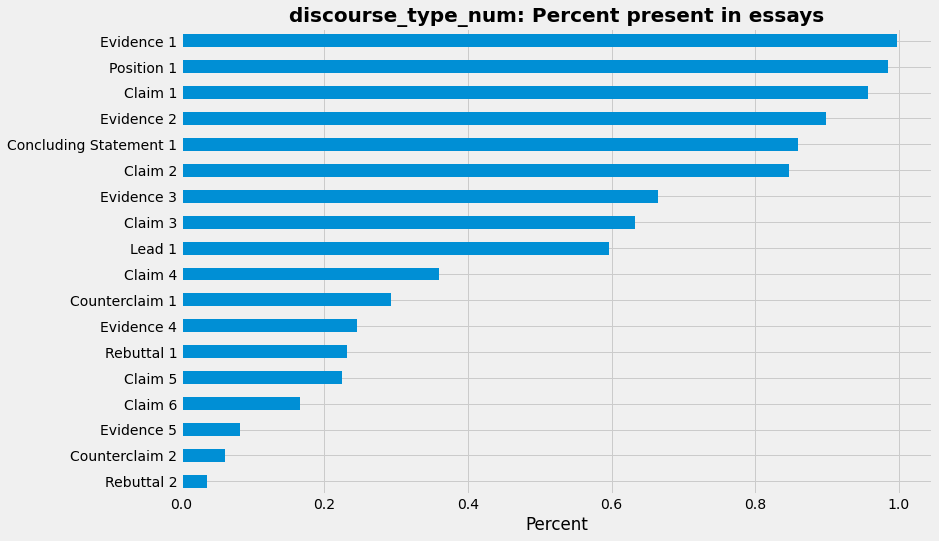

In [38]:
fig = plt.figure(figsize=(12,8))
av_per_essay = train['discourse_type_num'].value_counts(ascending = True).rename_axis('discourse_type_num').reset_index(name='count')
av_per_essay['perc'] = round((av_per_essay['count'] / train.id.nunique()),3)
av_per_essay = av_per_essay.set_index('discourse_type_num')
ax = av_per_essay.query('perc > 0.03')['perc'].plot(kind="barh")
ax.set_title("discourse_type_num: Percent present in essays", fontsize=20, fontweight = 'bold')
ax.set_xlabel("Percent")
ax.set_ylabel("")
plt.show()

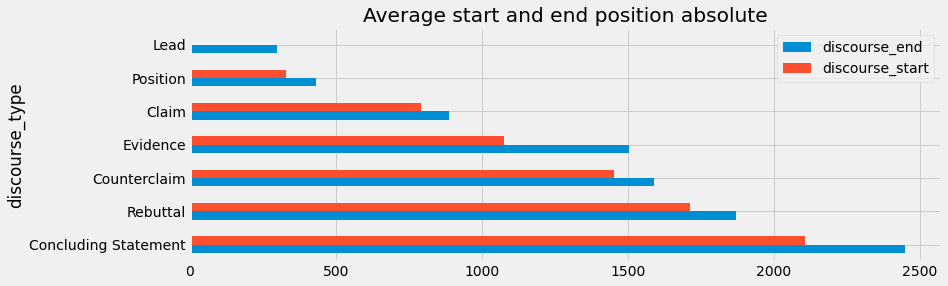

In [39]:
data = train.groupby("discourse_type")[['discourse_end', 'discourse_start']].mean().reset_index().sort_values(by = 'discourse_start', ascending = False)
data.plot(x='discourse_type',
        kind='barh',
        stacked=False,
        title='Average start and end position absolute',
        figsize=(12,4))
plt.show()

In [43]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

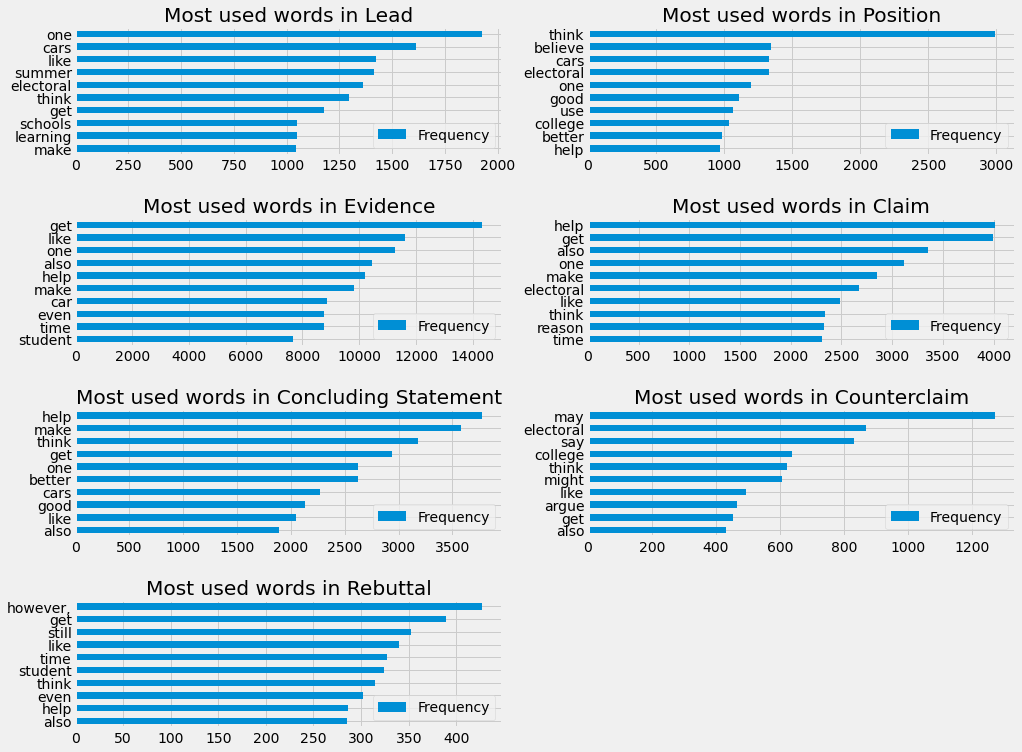

In [44]:
train['discourse_text'] = train['discourse_text'].str.lower()

#get stopwords from nltk library
stop_english = stopwords.words("english")
other_words_to_take_out = ['school', 'students', 'people', 'would', 'could', 'many']
stop_english.extend(other_words_to_take_out)

#put dataframe of Top-10 words in dict for all discourse types
counts_dict = {}
for dt in train['discourse_type'].unique():
    df = train.query('discourse_type == @dt')
    text = df.discourse_text.apply(lambda x: x.split()).tolist()
    text = [item for elem in text for item in elem]
    df1 = pd.Series(text).value_counts().to_frame().reset_index()
    df1.columns = ['Word', 'Frequency']
    df1 = df1[~df1.Word.isin(stop_english)].head(10)
    df1 = df1.set_index("Word").sort_values(by = "Frequency", ascending = True)
    counts_dict[dt] = df1

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

keys = list(counts_dict.keys())

for n, key in enumerate(keys):
    ax = plt.subplot(4, 2, n + 1)
    ax.set_title(f"Most used words in {key}")
    counts_dict[keys[n]].plot(ax=ax, kind = 'barh')
    plt.ylabel("")

plt.show()

In [45]:
def get_n_grams(n_grams, top_n = 10):
    df_words = pd.DataFrame()
    for dt in tqdm(train['discourse_type'].unique()):
        df = train.query('discourse_type == @dt')
        texts = df['discourse_text'].tolist()
        vec = CountVectorizer(lowercase = True, stop_words = 'english',\
                              ngram_range=(n_grams, n_grams)).fit(texts)
        bag_of_words = vec.transform(texts)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        cvec_df = pd.DataFrame.from_records(words_freq,\
                                            columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
        cvec_df.insert(0, "Discourse_type", dt)
        cvec_df = cvec_df.iloc[:top_n,:]
        df_words = df_words.append(cvec_df)
    return df_words

In [46]:
bigrams = get_n_grams(n_grams = 2, top_n=10)
bigrams.head()

  0%|          | 0/7 [00:00<?, ?it/s]

,Discourse_type,words,counts
73564,Lead,electoral college,1179
63518,Lead,driverless cars,808
55,Lead,cell phones,592
19359,Lead,summer projects,513
85397,Lead,distance learning,468


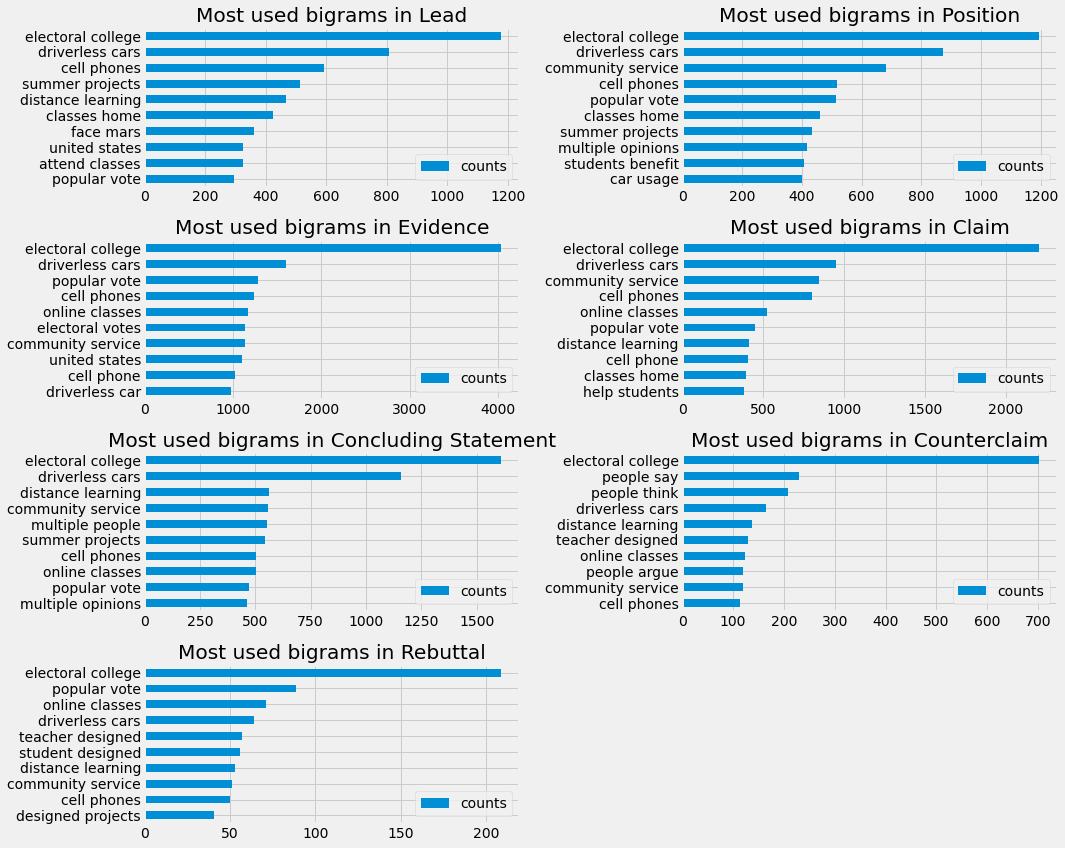

In [47]:
def plot_ngram(df, type = "bigrams"):
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for n, dt in enumerate(df.Discourse_type.unique()):
        ax = plt.subplot(4, 2, n + 1)
        ax.set_title(f"Most used {type} in {dt}")
        data = df.query('Discourse_type == @dt')[['words', 'counts']].set_index("words").sort_values(by = "counts", ascending = True)
        data.plot(ax=ax, kind = 'barh')
        plt.ylabel("")
    plt.tight_layout()
    plt.show()
    
plot_ngram(bigrams)

  0%|          | 0/7 [00:00<?, ?it/s]

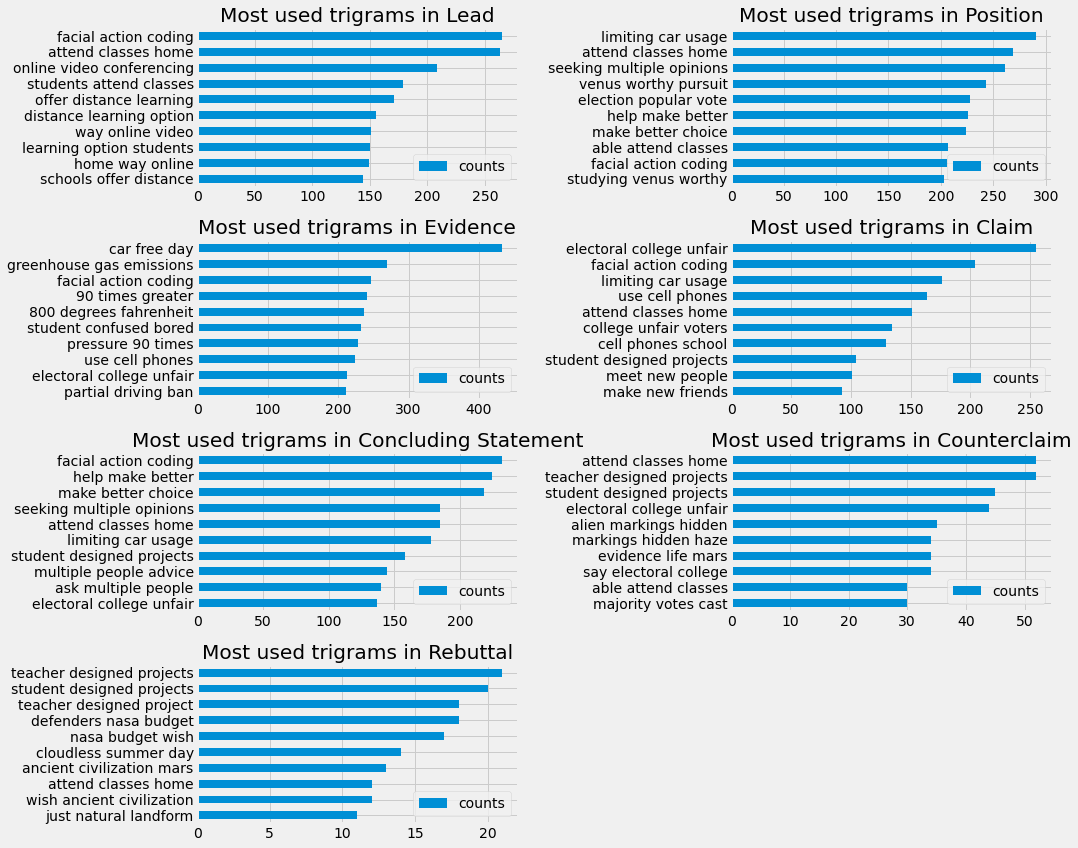

In [48]:
trigrams = get_n_grams(n_grams = 3, top_n=10)
plot_ngram(trigrams, type = "trigrams")